# Heart Disease Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#EDA
from collections import Counter
# import pandas_profiling as pp
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix , accuracy_score , roc_curve,classification_report , auc , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#ensembling
# from mlxtend.classifier import StackingCVClassifier

In [2]:
data = pd.read_csv('heart.csv')
data.shape

(1025, 14)

In [3]:
data.isnull().sum().head()

age         0
sex         0
cp          0
trestbps    0
chol        0
dtype: int64

In [4]:
# concise summary of our dataset.
# data.info()
# Generating descriptive statistics.
# data.describe().T

## EDA

### Distribution Plot - Age

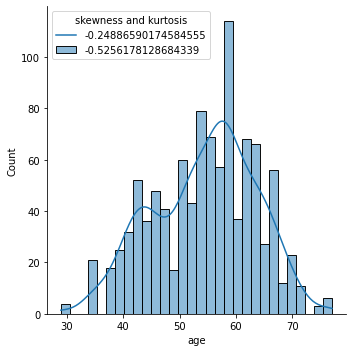

In [5]:
#create a distribution plot with normal distribution curve
sns.displot( x = 'age', data = data, bins = 30, kde = True)
skewness=str(data["age"].skew())
kurtosis=str(data["age"].kurt())
plt.legend([skewness,kurtosis],title=("skewness and kurtosis"))
plt.show();

### Countplots

#### 1) Heart Disease Frequency wrt Sex

In [6]:
pd.crosstab(data.target, data.sex)

sex,0,1
target,,
0,86,413
1,226,300


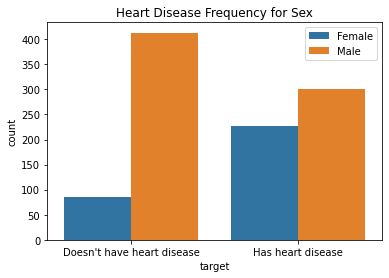

In [7]:
fig = sns.countplot(x = 'target', data = data, hue = 'sex')
fig.set_xticklabels(labels=["Doesn't have heart disease", 'Has heart disease'], rotation=0)
plt.legend(['Female', 'Male'])
plt.title("Heart Disease Frequency for Sex");

#### 2)Heart Disease wrt Chest Pain Type

In [8]:
pd.crosstab(data.target, data.cp)

cp,0,1,2,3
target,,,,
0,375,33,65,26
1,122,134,219,51


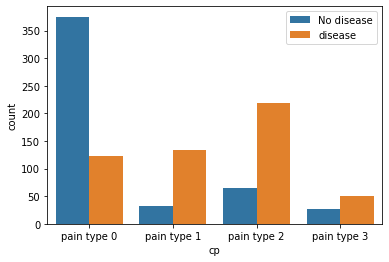

In [9]:
fig = sns.countplot(x = 'cp', data = data, hue = 'target')
fig.set_xticklabels(labels=['pain type 0', 'pain type 1', 'pain type 2', 'pain type 3'], rotation=0)
plt.legend(['No disease', 'disease']);

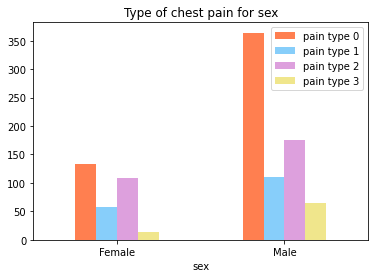

In [10]:
fig = pd.crosstab(data.sex, data.cp).plot(kind = 'bar', color = ['coral', 'lightskyblue', 'plum', 'khaki'])
plt.title('Type of chest pain for sex')
fig.set_xticklabels(labels=['Female', 'Male'], rotation=0)
plt.legend(['pain type 0', 'pain type 1', 'pain type 2', 'pain type 3']);

### KDE featues continous plots

In [11]:
# numerical 
num_feats = ["age", 'trestbps', 'chol' , 'oldpeak' ,'thalach']
# categorical (binary)
bin_feats = ['sex' ,'fbs' ,'exang' ,'target']
# caterorical (multi-)
nom_feats= ['cp', 'restecg' ,'slope' ,'ca' ,'thal']
cat_feats = nom_feats + bin_feats

In [12]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))
#remove_last= (nrow * ncol) - L

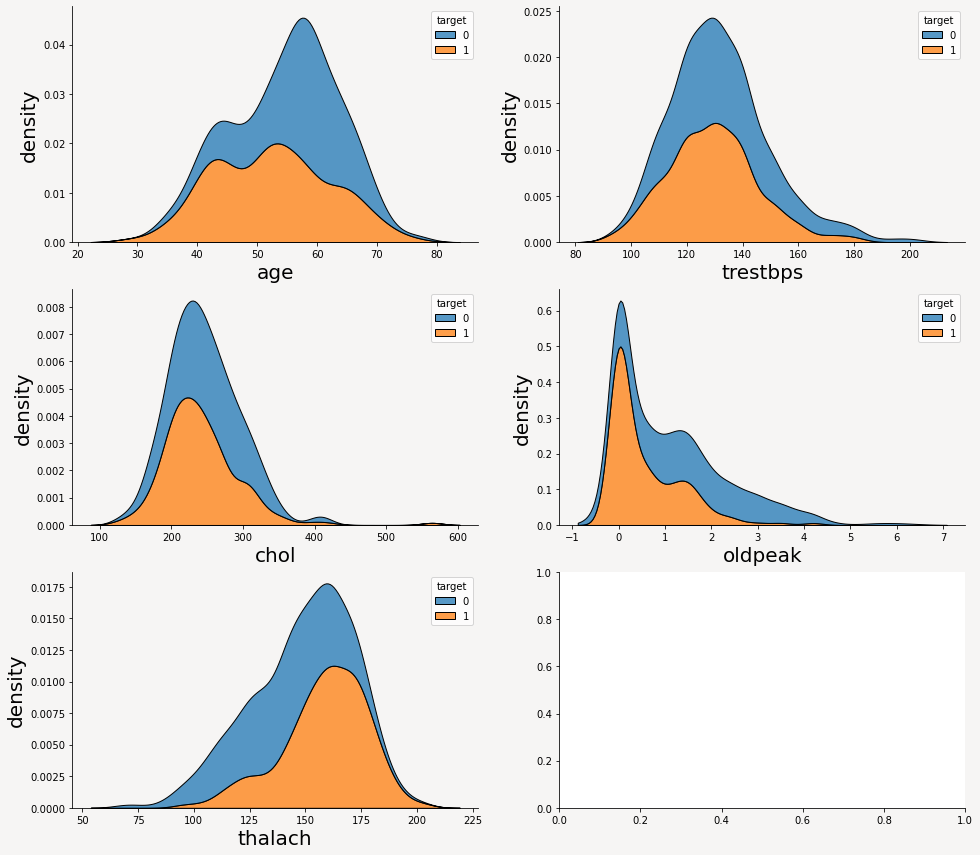

In [13]:
fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='#F6F5F4')   
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
    
    ax = sns.kdeplot(data=data, x=col , hue="target", multiple="stack") 
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)
    
    i = i +1

### Categorical features count-plot

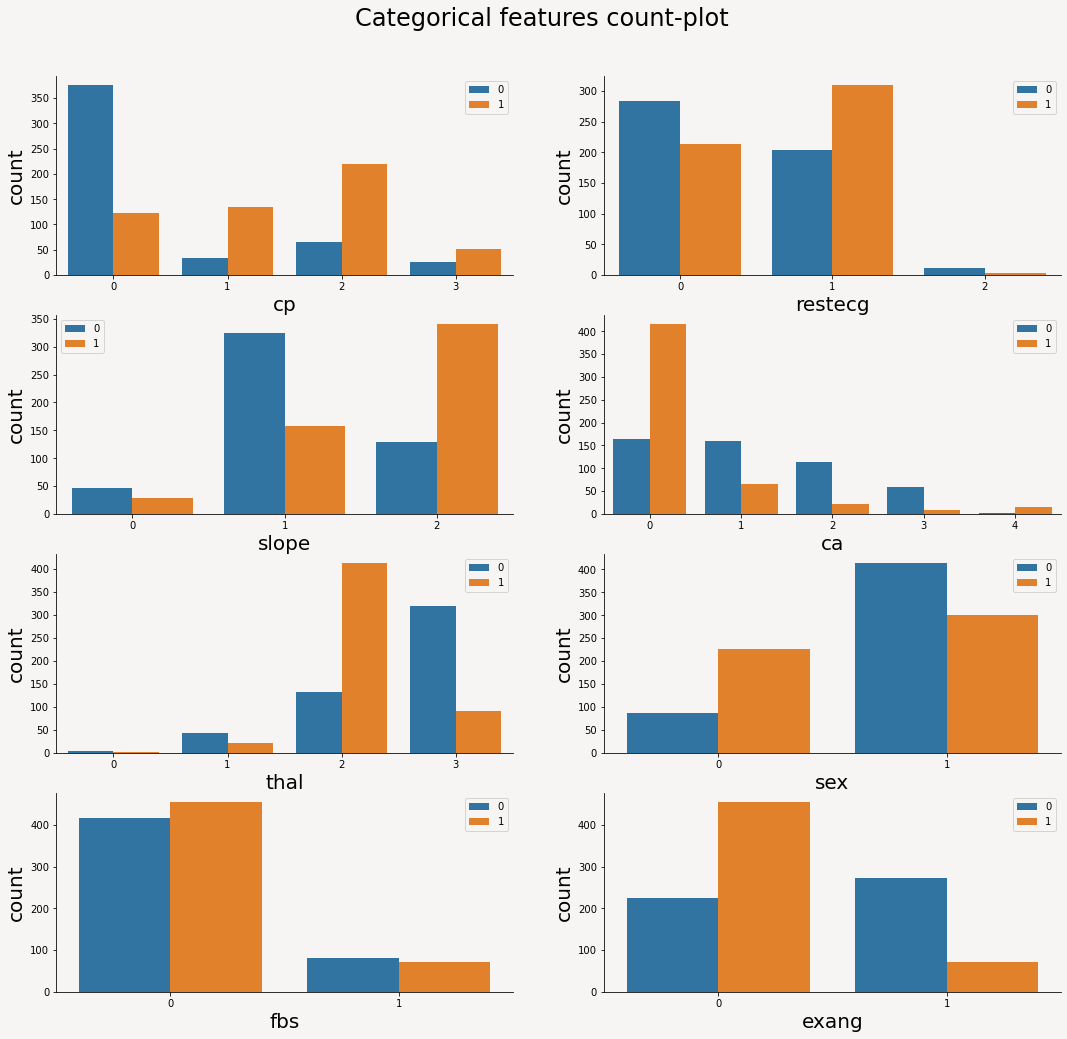

In [14]:
def hist_plot(data, cat_feats):    
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 16), facecolor='#F6F5F4')    
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        g = sns.countplot(data=data, x=col, hue="target")
        g.set_xlabel(col, fontsize=20)
        g.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False) 
        plt.legend(facecolor='#F6F5F4')
        i = i +1

    plt.suptitle('Categorical features count-plot' ,fontsize = 24)
    return 0

hist_plot(data, cat_feats[0:-1]);

### Pair Plot

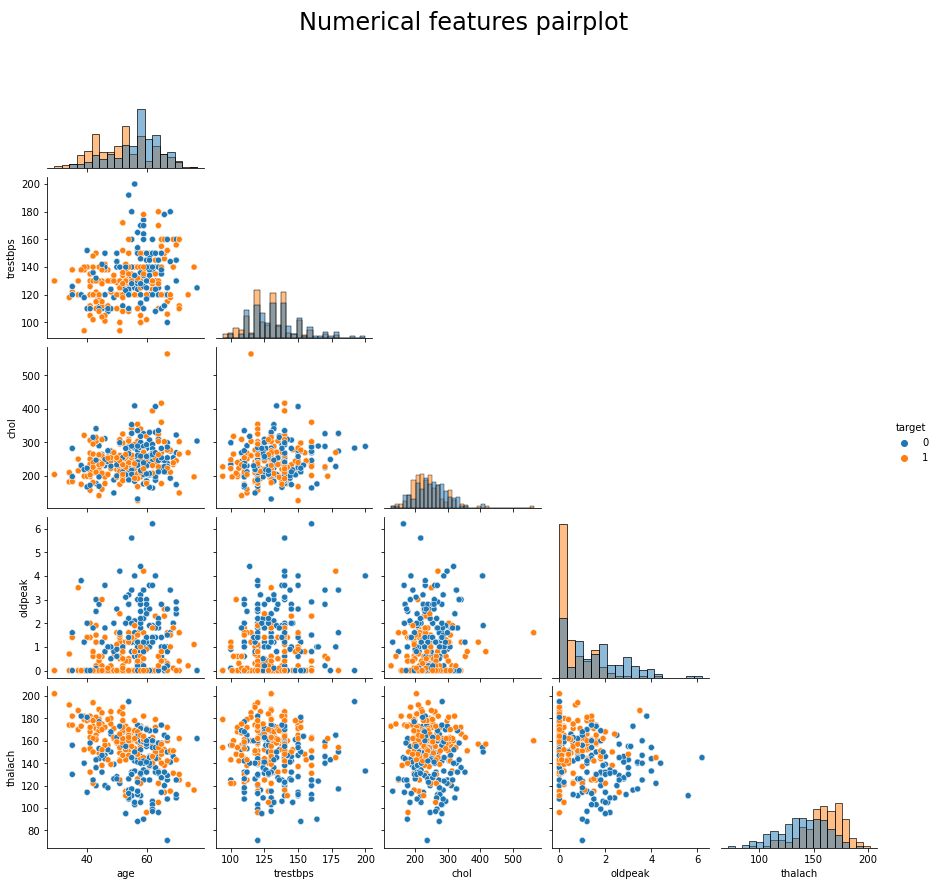

In [15]:
num_feats_plus_target = ["age", 'trestbps', 'chol' , 'oldpeak' ,'thalach' , 'target']

g = sns.pairplot(data=data[num_feats_plus_target], hue="target", corner=True, diag_kind='hist');

plt.suptitle('Numerical features pairplot' ,fontsize = 24);

### Corelation Heatmap

The *`Pearson correlation coefficient`* ― is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus it is essentially a normalised measurement of the covariance, such that the result always has a value between −1 and 1.

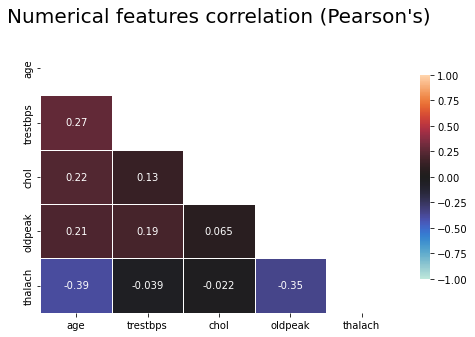

In [16]:
df_ = data[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
sns.heatmap(corr, mask=mask,  vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

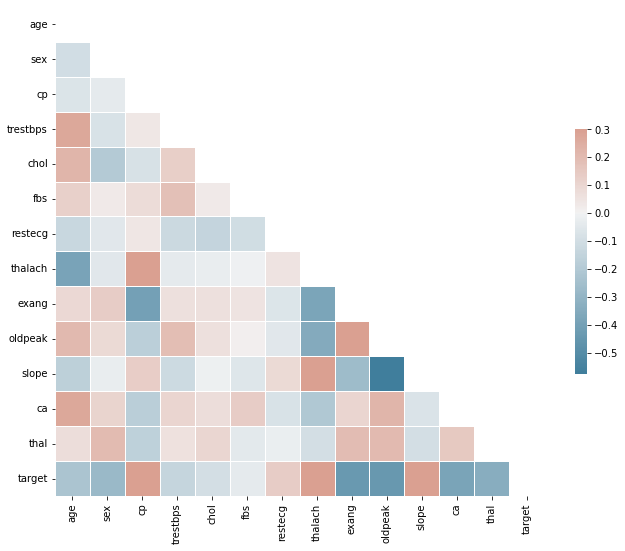

In [17]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Data setting for model

In [18]:
X = data.drop('target',axis=1)
y = data["target"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

checking if data is evenly splitted

In [21]:
print(y_test.unique())
Counter(y_train)

[1 0]


Counter({1: 419, 0: 401})

## Model

### Logistic Regression

In [22]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[ 77  21]
 [  7 100]]


Accuracy of Logistic Regression: 86.34146341463415 

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        98
           1       0.83      0.93      0.88       107

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.87      0.86      0.86       205



### Naive Bayes

In [23]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[79 19]
 [11 96]]


Accuracy of Naive Bayes model: 85.36585365853658 

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        98
           1       0.83      0.90      0.86       107

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205



### Random Forest Classifier

In [24]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=2,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[ 89   9]
 [  2 105]]


Accuracy of Random Forest: 94.6341463414634 

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        98
           1       0.92      0.98      0.95       107

    accuracy                           0.95       205
   macro avg       0.95      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205



### XGB

In [25]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[ 86  12]
 [  6 101]]


Accuracy of Extreme Gradient Boost: 91.21951219512195 

              precision    recall  f1-score   support

           0       0.93      0.88      0.91        98
           1       0.89      0.94      0.92       107

    accuracy                           0.91       205
   macro avg       0.91      0.91      0.91       205
weighted avg       0.91      0.91      0.91       205



### KNN

In [26]:
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[84 14]
 [11 96]]


Accuracy of K-NeighborsClassifier: 87.8048780487805 

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        98
           1       0.87      0.90      0.88       107

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



### Decision Tree

In [27]:
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[95  3]
 [ 8 99]]


Accuracy of DecisionTreeClassifier: 94.6341463414634 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        98
           1       0.97      0.93      0.95       107

    accuracy                           0.95       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205



### SVM

In [28]:
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[ 94   4]
 [  0 107]]


Accuracy of Support Vector Classifier: 98.04878048780488 

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        98
           1       0.96      1.00      0.98       107

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



## Model Evaluation

In [29]:
model_names = ['Logistic Regression',
                'Naive Bayes',
                'Random Forest',
                'Extreme Gradient Boost',
                'K-Nearest Neighbour',
                'Decision Tree',
                'Support Vector Machine'
                ]

In [30]:
classifiers = [
    LogisticRegression(solver="liblinear"),
    GaussianNB(),
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(10),
    DecisionTreeClassifier(),
    SVC(probability=True),
]

In [31]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Support Vector Machine'], 'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,knn_acc_score*100,dt_acc_score*100,svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,86.341463
1,Naive Bayes,85.365854
2,Random Forest,94.634146
3,Extreme Gradient Boost,91.219512
4,K-Nearest Neighbour,87.804878
5,Decision Tree,94.634146
6,Support Vector Machine,98.048780


### Score Summary

In [32]:
def score_summary(names, classifiers):
    '''
    Given a list of classiers, this function calculates the accuracy, 
    ROC_AUC and Recall and returns the values in a dataframe
    '''
    
    cols=["Classifier", "Accuracy", "ROC_AUC", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)
    
    for name, clf in zip(names, classifiers):        
        clf.fit(X_train, y_train)
        
        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred)

        pred_proba = clf.predict_proba(X_test)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)        
        roc_auc = auc(fpr, tpr)
        
        # confusion matric, cm
        cm = confusion_matrix(y_test, pred) 
        
        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])
        
        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])
        
        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)     

    return(np.round(data_table.reset_index(drop=True), 2))

In [33]:
score_summary(model_names, classifiers).sort_values(by='Accuracy' , ascending = False)\
.style.background_gradient(cmap='coolwarm')\
.bar(subset=["ROC_AUC",], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1
2,Random Forest,100.000000,1.000000,1.000000,1.000000,1.000000
3,Extreme Gradient Boost,100.000000,1.000000,1.000000,1.000000,1.000000
5,Decision Tree,100.000000,1.000000,1.000000,1.000000,1.000000
6,Support Vector Machine,96.590000,0.990000,0.990000,0.950000,0.970000
4,K-Nearest Neighbour,87.800000,0.950000,0.900000,0.870000,0.880000
0,Logistic Regression,86.340000,0.940000,0.930000,0.830000,0.880000
1,Naive Bayes,85.370000,0.930000,0.900000,0.830000,0.860000


### roc_auc curve

In [34]:
def roc_auc_curve(names, classifiers):
    '''
    Given a list of classifiers, this function plots the ROC curves
    
    '''       
    plt.figure(figsize=(12, 8))   
        
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        
        pred_proba = clf.predict_proba(X_test)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")
                

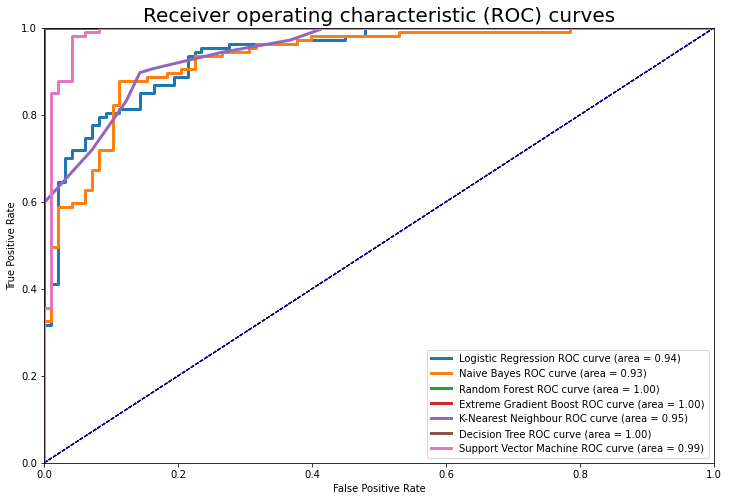

In [35]:
roc_auc_curve(model_names, classifiers)